# Predviđanje popularnosti online članaka

### Jovan Jurić 1206

Zadatak ovog projekta je predviđanje popularnosti online članaka. Dataset je preuzet sa ovog __[linka](http://archive.ics.uci.edu/ml/datasets/Online+News+Popularity)__.

In [38]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, KFold, train_test_split
import seaborn as sb
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [39]:
#Read data
data = pd.read_csv('./dataset.csv',sep=',',skipinitialspace=True)
data

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,http://mashable.com/2014/12/27/samsung-app-aut...,8.0,11.0,346.0,0.529052,1.0,0.684783,9.0,7.0,1.0,...,0.100000,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000,1800
39640,http://mashable.com/2014/12/27/seth-rogen-jame...,8.0,12.0,328.0,0.696296,1.0,0.885057,9.0,7.0,3.0,...,0.136364,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000,1900
39641,http://mashable.com/2014/12/27/son-pays-off-mo...,8.0,10.0,442.0,0.516355,1.0,0.644128,24.0,1.0,12.0,...,0.136364,0.50,-0.356439,-0.800,-0.166667,0.454545,0.136364,0.045455,0.136364,1900
39642,http://mashable.com/2014/12/27/ukraine-blasts/,8.0,6.0,682.0,0.539493,1.0,0.692661,10.0,1.0,1.0,...,0.062500,0.50,-0.205246,-0.500,-0.012500,0.000000,0.000000,0.500000,0.000000,1100


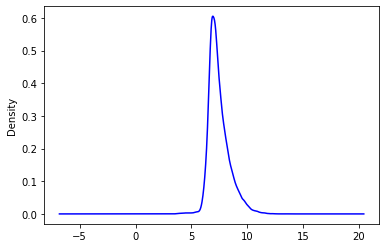

In [40]:
modified_data = np.log(data['shares'])
data['shares'] = modified_data
data['shares'].plot(kind='kde', color='blue')

Svako preprocesiranje dataseta je izvršeno pre njegovog objavljivanja tako da ne postoje nikakve nevalidne odnosno prazne vrednosti. 

Možemo uočiti da su nam podaci iz prve dve kolone (URL i broj dana koji je protekao između objavljivanja članaka i preuzimanja podataka) beznačajne za predviđanje naših podataka tako da ćemo ih odmah izbaciti iz upotrebe.

Što znači da imamo 58 atributa za predviđanje i jednu ciljnu vrednost (broj share-ova) kao i gotovo 40.000 entiteta.

In [41]:
x = data.iloc[:,2:-1]
column_names = x.columns
y = modified_data

U nastavku je data deskriptivna analiza podataka ulaznih podataka.

In [42]:
x.describe()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,10.398749,546.514731,0.548216,0.996469,0.689175,10.883690,3.293638,4.544143,1.249874,4.548239,...,0.353825,0.095446,0.756728,-0.259524,-0.521944,-0.107500,0.282353,0.071425,0.341843,0.156064
std,2.114037,471.107508,3.520708,5.231231,3.264816,11.332017,3.855141,8.309434,4.107855,0.844406,...,0.104542,0.071315,0.247786,0.127726,0.290290,0.095373,0.324247,0.265450,0.188791,0.226294
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000
25%,9.000000,246.000000,0.470870,1.000000,0.625739,4.000000,1.000000,1.000000,0.000000,4.478404,...,0.306244,0.050000,0.600000,-0.328383,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000
50%,10.000000,409.000000,0.539226,1.000000,0.690476,8.000000,3.000000,1.000000,0.000000,4.664082,...,0.358755,0.100000,0.800000,-0.253333,-0.500000,-0.100000,0.150000,0.000000,0.500000,0.000000
75%,12.000000,716.000000,0.608696,1.000000,0.754630,14.000000,4.000000,4.000000,1.000000,4.854839,...,0.411428,0.100000,1.000000,-0.186905,-0.300000,-0.050000,0.500000,0.150000,0.500000,0.250000
max,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,116.000000,128.000000,91.000000,8.041534,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000


Zatim vršimo i analizu share-ova.

In [43]:
y.describe()

count    39644.000000
mean         7.474855
std          0.930486
min          0.000000
25%          6.852243
50%          7.244228
75%          7.937375
max         13.645078
Name: shares, dtype: float64

Naredni graf nam prikazuje distribuciju share-ova.

Pošto imamo podatke gde svaki atribut ima različiti opseg vrednosti potrebno je izvršiti skaliranje podataka po kolonama kako bi svi podaci bili pozitivni i u opsegu <bold>[0,1]</bold>.

In [44]:
for column in x.columns:
    min_max_scaler = MinMaxScaler()
    x[column] = min_max_scaler.fit_transform(x[column].values.reshape(-1,1))

Pošto želimo da vršimo klasifikaciju o tome da li će članak biti popularan ili ne tu pretpostavku ćemo izvršiti tako što ćemo obeležiti sve članke koji imaju više od 1400 share-ova kao popularne. Takođe ćemo podatke prebaciti u tip np.array.

In [45]:
x = np.array(x)
y = np.array([i>7.244228 for i in y])

Zatim delimo podatke na skupove za treniranje i testiranje. 

In [46]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, train_size=0.7)

In [47]:
#Ova metoda prikazuje najbitnije fičure kod modela
def plot_feature_importance(model):
    plt.title('Feature importance')   
    column_names_top_10 = [item for _,item in sorted(zip(model.feature_importances_[1:],column_names),reverse=True)]
    column_names_top_10 = column_names_top_10[:10]
    feature_importance_top_10 = sorted(model.feature_importances_[:-1],reverse=True)[:10]
    plt.barh(column_names_top_10, feature_importance_top_10)
    plt.show()
    
#Ova metoda služi za treniranje modela i prikazivanje rezultata testiranja
def run_model(model,print_feature_importance=False):
    print('*'*75)
    print('Model class:',type(model))
    trained_model = model.fit(x_train,y_train)
    print('Model test score:',trained_model.score(x_test,y_test))
    pred = trained_model.predict(x_test)
    cross_val_results = cross_val_score(model,x,y)
    print('Cross validation results (5 fold):',cross_val_results)
    print(classification_report(y_test,pred))
    auc = roc_auc_score(y_test,pred)
    print('AUC score:',auc)
    cm = confusion_matrix(y_test,pred)
    cm_df = pd.DataFrame(cm,[0,1],[0,1])
    group_names=['TN','FP','FN','TP']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.title('Confusion matrix heatmap')
    sb.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.show()
    
    #Calculate AUC curve
    fpr,tpr,_ = roc_curve(y_test,pred)
    
    plt.title('ROC curve')
    plt.plot(fpr,tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    print('*'*75)

***************************************************************************
Model class: <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Model test score: 0.6286362872036321
Cross validation results (5 fold): [0.60739059 0.61054357 0.63009207 0.63955102 0.62840565]
              precision    recall  f1-score   support

       False       0.62      0.69      0.65      5980
        True       0.64      0.57      0.60      5914

    accuracy                           0.63     11894
   macro avg       0.63      0.63      0.63     11894
weighted avg       0.63      0.63      0.63     11894

AUC score: 0.6282977979806434


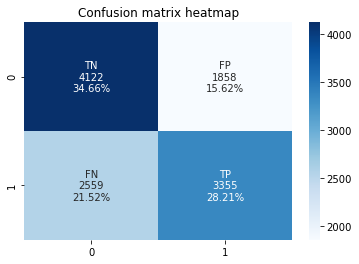

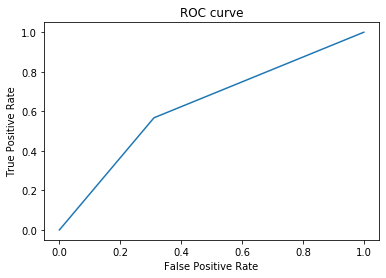

***************************************************************************


In [54]:
knn = KNeighborsClassifier(n_neighbors=50)
run_model(knn)

***************************************************************************
Model class: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Model test score: 0.647301160248865
Cross validation results (5 fold): [0.49375709 0.61457939 0.65607264 0.67095472 0.65110999]
              precision    recall  f1-score   support

       False       0.64      0.67      0.66      5980
        True       0.65      0.62      0.64      5914

    accuracy                           0.65     11894
   macro avg       0.65      0.65      0.65     11894
weighted avg       0.65      0.65      0.65     11894

AUC score: 0.6471629306571449


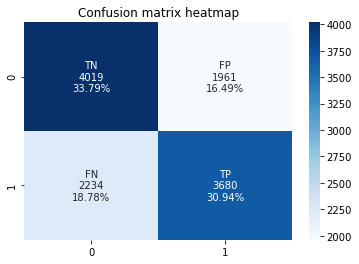

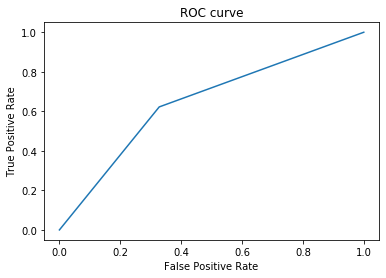

***************************************************************************


In [49]:
logreg = LogisticRegression(max_iter=100000)
run_model(logreg)

***************************************************************************
Model class: <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
Model test score: 0.6674794013788464
Cross validation results (5 fold): [0.51746752 0.61975028 0.65657712 0.66931517 0.66372351]
              precision    recall  f1-score   support

       False       0.66      0.69      0.68      5980
        True       0.67      0.64      0.66      5914

    accuracy                           0.67     11894
   macro avg       0.67      0.67      0.67     11894
weighted avg       0.67      0.67      0.67     11894

AUC score: 0.6673548566238721


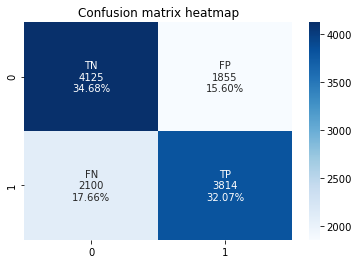

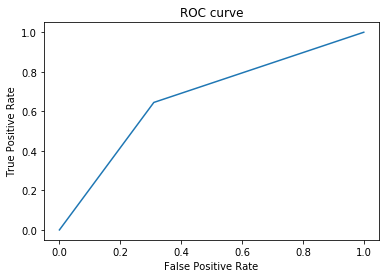

***************************************************************************


In [50]:
ada = AdaBoostClassifier(n_estimators=200, random_state=0)
run_model(ada)

***************************************************************************
Model class: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Model test score: 0.6735328737178409
Cross validation results (5 fold): [0.54660108 0.6505234  0.65733384 0.6753689  0.66422805]
              precision    recall  f1-score   support

       False       0.67      0.69      0.68      5980
        True       0.68      0.66      0.67      5914

    accuracy                           0.67     11894
   macro avg       0.67      0.67      0.67     11894
weighted avg       0.67      0.67      0.67     11894

AUC score: 0.6734654348900574


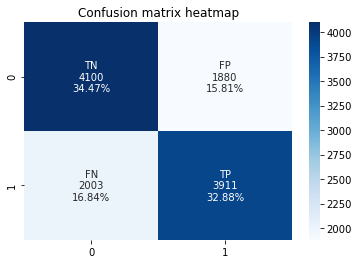

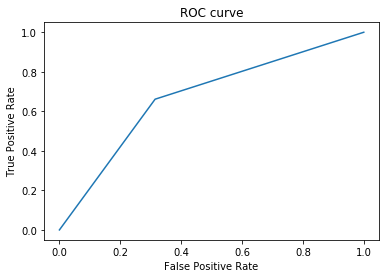

***************************************************************************


In [51]:
rand_forest = RandomForestClassifier(max_depth=50,n_estimators=400)
run_model(rand_forest)

Iz dobijenih rezultata treniranja modela možemo zaključiti da je RandomForestClassifier najbolji model za predviđanje naših rezultata. U nastavku ćemo iz našeg modela videti koji su fičeri najbitniji (10 najbitnijih) u predviđanju rezultata.

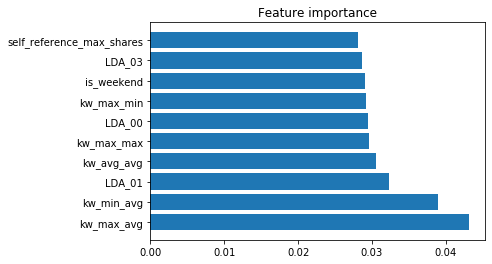

In [52]:
plot_feature_importance(rand_forest)

Odvade možemo zaključiti da su za predviđanje popularnosti online članaka najbitnije ključne reči koje se koriste u nasolvima, srodnost nekim od kategorija LDA_0x (autor dataseta naveo je da su ovo neke kategorije koje su izračunate metodama procesiranja prirodnih jezika) kao i to da li je članak postavljen za vikend.